In [1]:
import glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("max_colwidth", 100)
sns.set(rc={"figure.figsize": (30, 14)})

In [22]:
files_list = glob.glob("./results/trump/*.json")
dfs = []
for f in files_list:
    embedding_retrieval_type = "_".join(f.split("_")[3:-1]) + "_pooling"
    df = pd.read_json(f)
    df["embedding_retrieval_type"] = embedding_retrieval_type
    dfs.append(df)

In [23]:
full_results = pd.concat(dfs)

In [24]:
full_results

,Dataset,Dataset Size,Model,Params,Scores,Computation Time,embedding_retrieval_type
0,../data/trump,44252,BERTopic,"{'embedding_model': 'sentence-transformers/all-mpnet-base-v2', 'nr_topics': 10, 'min_topic_size'...","{'npmi': -0.018553912332308003, 'diversity': 0.7333333333333331}",74.815693,embedding_concat_last_four_layers_cls_pooling
1,../data/trump,44252,BERTopic,"{'embedding_model': 'sentence-transformers/all-mpnet-base-v2', 'nr_topics': 20, 'min_topic_size'...","{'npmi': -0.004013104557121, 'diversity': 0.726315789473684}",70.482574,embedding_concat_last_four_layers_cls_pooling
2,../data/trump,44252,BERTopic,"{'embedding_model': 'sentence-transformers/all-mpnet-base-v2', 'nr_topics': 30, 'min_topic_size'...","{'npmi': -0.026348133108243, 'diversity': 0.7241379310344821}",70.276509,embedding_concat_last_four_layers_cls_pooling
3,../data/trump,44252,BERTopic,"{'embedding_model': 'sentence-transformers/all-mpnet-base-v2', 'nr_topics': 40, 'min_topic_size'...","{'npmi': -0.027106034621433003, 'diversity': 0.756410256410256}",70.597795,embedding_concat_last_four_layers_cls_pooling
4,../data/trump,44252,BERTopic,"{'embedding_model': 'sentence-transformers/all-mpnet-base-v2', 'nr_topics': 50, 'min_topic_size'...","{'npmi': -0.038648069954321004, 'diversity': 0.763265306122449}",71.637566,embedding_concat_last_four_layers_cls_pooling
...,...,...,...,...,...,...,...
0,../data/trump,44252,BERTopic,"{'embedding_model': 'sentence-transformers/all-mpnet-base-v2', 'nr_topics': 10, 'min_topic_size'...","{'npmi': -0.056956412642097005, 'diversity': 0.8111111111111111}",59.355990,embedding_sum_last_four_layers_mean_pooling
1,../data/trump,44252,BERTopic,"{'embedding_model': 'sentence-transformers/all-mpnet-base-v2', 'nr_topics': 20, 'min_topic_size'...","{'npmi': -0.053212182027106, 'diversity': 0.7947368421052631}",57.698312,embedding_sum_last_four_layers_mean_pooling
2,../data/trump,44252,BERTopic,"{'embedding_model': 'sentence-transformers/all-mpnet-base-v2', 'nr_topics': 30, 'min_topic_size'...","{'npmi': -0.06176717112403501, 'diversity': 0.6827586206896551}",57.341523,embedding_sum_last_four_layers_mean_pooling
3,../data/trump,44252,BERTopic,"{'embedding_model': 'sentence-transformers/all-mpnet-base-v2', 'nr_topics': 40, 'min_topic_size'...","{'npmi': -0.034512000505226, 'diversity': 0.6717948717948711}",58.497076,embedding_sum_last_four_layers_mean_pooling


In [25]:
keys_to_extract = ["embedding_model", "nr_topics", "min_topic_size"]
for key in keys_to_extract:
    full_results[key] = full_results["Params"].apply(lambda x: x.get(key, None))
full_results.drop("Params", axis=1, inplace=True)

In [26]:
keys_to_extract = ["npmi", "diversity"]
for key in keys_to_extract:
    full_results[key] = full_results["Scores"].apply(lambda x: x.get(key, None))
full_results.drop("Scores", axis=1, inplace=True)

In [27]:
results_grouped = full_results.groupby(
    [full_results["embedding_retrieval_type"], full_results["nr_topics"]], as_index=False
)[["nr_topics", "npmi", "diversity", "Computation Time"]].mean()

In [28]:
def rename_embedding_type(name):
    # Split the name into parts
    parts = name.split("_")

    # Define the new names for each part
    new_name_parts = {
        "concat": "Concat",
        "sum": "Sum",
        "last": "Last",
        "second": "Second",
        "all": "All",
        "four": "Four",
        "layers": "Layers",
        "layer": "Layer",
        "output": "Output",
        "hidden": "Hidden",
    }

    # Determine the pooling type and place it in parentheses
    pooling = parts[-2].upper() if parts[-2] == "cls" else parts[-2].capitalize()
    pooling_type = f"({pooling} Pooling)"

    # Check for 'embedding_layer' to include "Embedding Layer" in the new name
    if "_".join(parts[:2]) == "embedding_layer":
        new_name = "Embedding Layer " + " ".join(
            new_name_parts.get(part, part.capitalize()) for part in parts[2:-2]
        )
    else:
        new_name = " ".join(new_name_parts.get(part, part.capitalize()) for part in parts[1:-2])

    # Add the pooling type
    new_name += " " + pooling_type

    # Remove extra spaces and return
    return " ".join(new_name.split())

In [29]:
results_grouped["embedding_retrieval_type"] = [rename_embedding_type(name) for name in results_grouped["embedding_retrieval_type"]]

In [30]:
results_sorted_npmi = (
    results_grouped.groupby("embedding_retrieval_type")
    .mean("npmi")
    .reset_index()
    .sort_values("npmi", ascending=False)
)
top_categories_npmi = results_sorted_npmi.head(5)["embedding_retrieval_type"].tolist()

In [31]:
results_sorted_npmi

,embedding_retrieval_type,nr_topics,npmi,diversity,Computation Time
10,Second Last Layer (Max Pooling),30.0,0.180241,0.476176,61.540825
13,Sum All Layers (Max Pooling),30.0,0.155908,0.488039,66.002766
16,Sum Last Four Layers (Max Pooling),30.0,0.149542,0.517296,63.638322
1,Concat Last Four Layers (Max Pooling),30.0,0.133072,0.496895,83.937841
12,Sum All Layers (CLS Pooling),30.0,0.098392,0.563166,59.778213
7,Last Hidden Layer (Max Pooling),30.0,0.081023,0.611062,62.411683
4,Embedding Layer Output (Max Pooling),30.0,0.063377,0.540028,70.481623
5,Embedding Layer Output (Mean Pooling),30.0,0.043953,0.799153,66.353681
11,Second Last Layer (Mean Pooling),30.0,0.021992,0.661322,59.218831
9,Second Last Layer (CLS Pooling),30.0,0.015919,0.609304,60.665142


In [32]:
results_sorted_diversity = (
    results_grouped.groupby("embedding_retrieval_type")
    .mean("diversity")
    .reset_index()
    .sort_values("diversity", ascending=False)
)
#results_sorted_diversity = results_sorted_diversity[results_sorted_diversity["embedding_retrieval_type"] != "Last Hidden Layer (Mean Pooling)"]
top_categories_diversity = results_sorted_diversity.head(5)["embedding_retrieval_type"].tolist()

In [33]:
default_setting = results_grouped[
    results_grouped["embedding_retrieval_type"] == "Last Hidden Layer (Mean Pooling)"
]

results_grouped = results_grouped[
    results_grouped["embedding_retrieval_type"] != "Last Hidden Layer (Mean Pooling)"
]

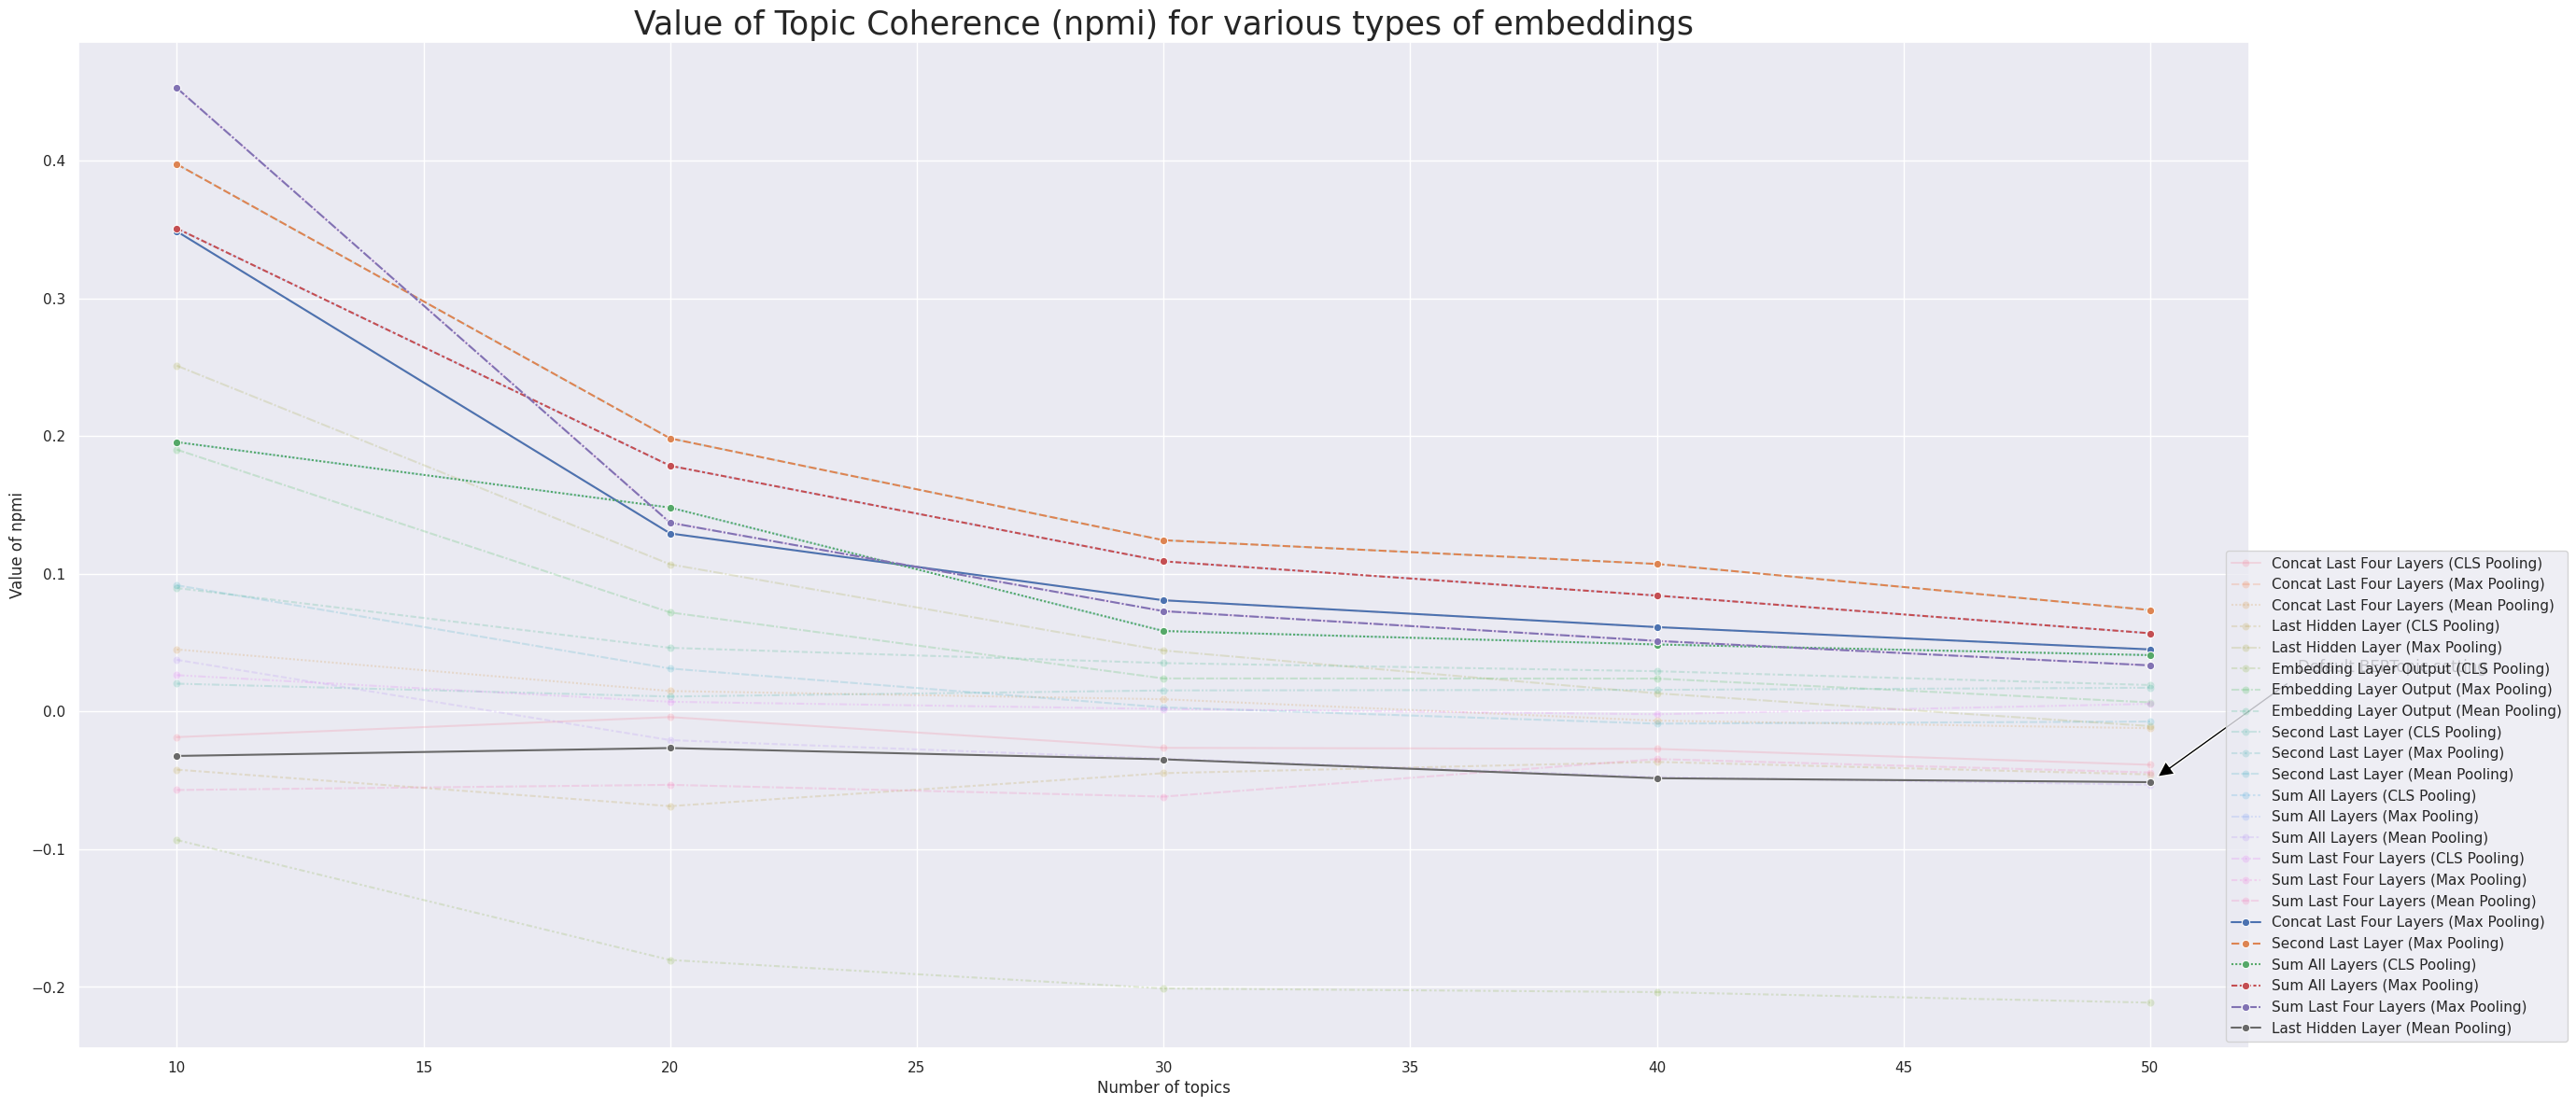

In [34]:
fig, ax = plt.subplots()
sns.lineplot(
    data=results_grouped,
    x="nr_topics",
    y="npmi",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=0.2,
    marker="o",
    ax=ax,
)
sns.lineplot(
    data=results_grouped[results_grouped["embedding_retrieval_type"].isin(top_categories_npmi)],
    x="nr_topics",
    y="npmi",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=1,
    marker="o",
    ax=ax,
)

sns.lineplot(
    data=default_setting,
    x="nr_topics",
    y="npmi",
    style="embedding_retrieval_type",
    color="dimgrey",
    alpha=1,
    marker="o",
    ax=ax,
)
plt.xlabel("Number of topics")
plt.ylabel("Value of npmi")
plt.title("Value of Topic Coherence (npmi) for various types of embeddings", size=25)

line = ax.lines[-2]
x_data = line.get_xdata()
y_data = line.get_ydata()
x_to_annotate = x_data[-1]
y_to_annotate = y_data[-1]

ax.annotate(
    "Default BERTopic setting",
    xy=(x_to_annotate, y_to_annotate),
    xytext=(x_to_annotate + 3, y_to_annotate + 0.08),
    arrowprops=dict(facecolor="black", shrink=0.05, width=2),
)

ax.legend(loc="lower right", bbox_to_anchor=(1.15, 0))
plt.show()

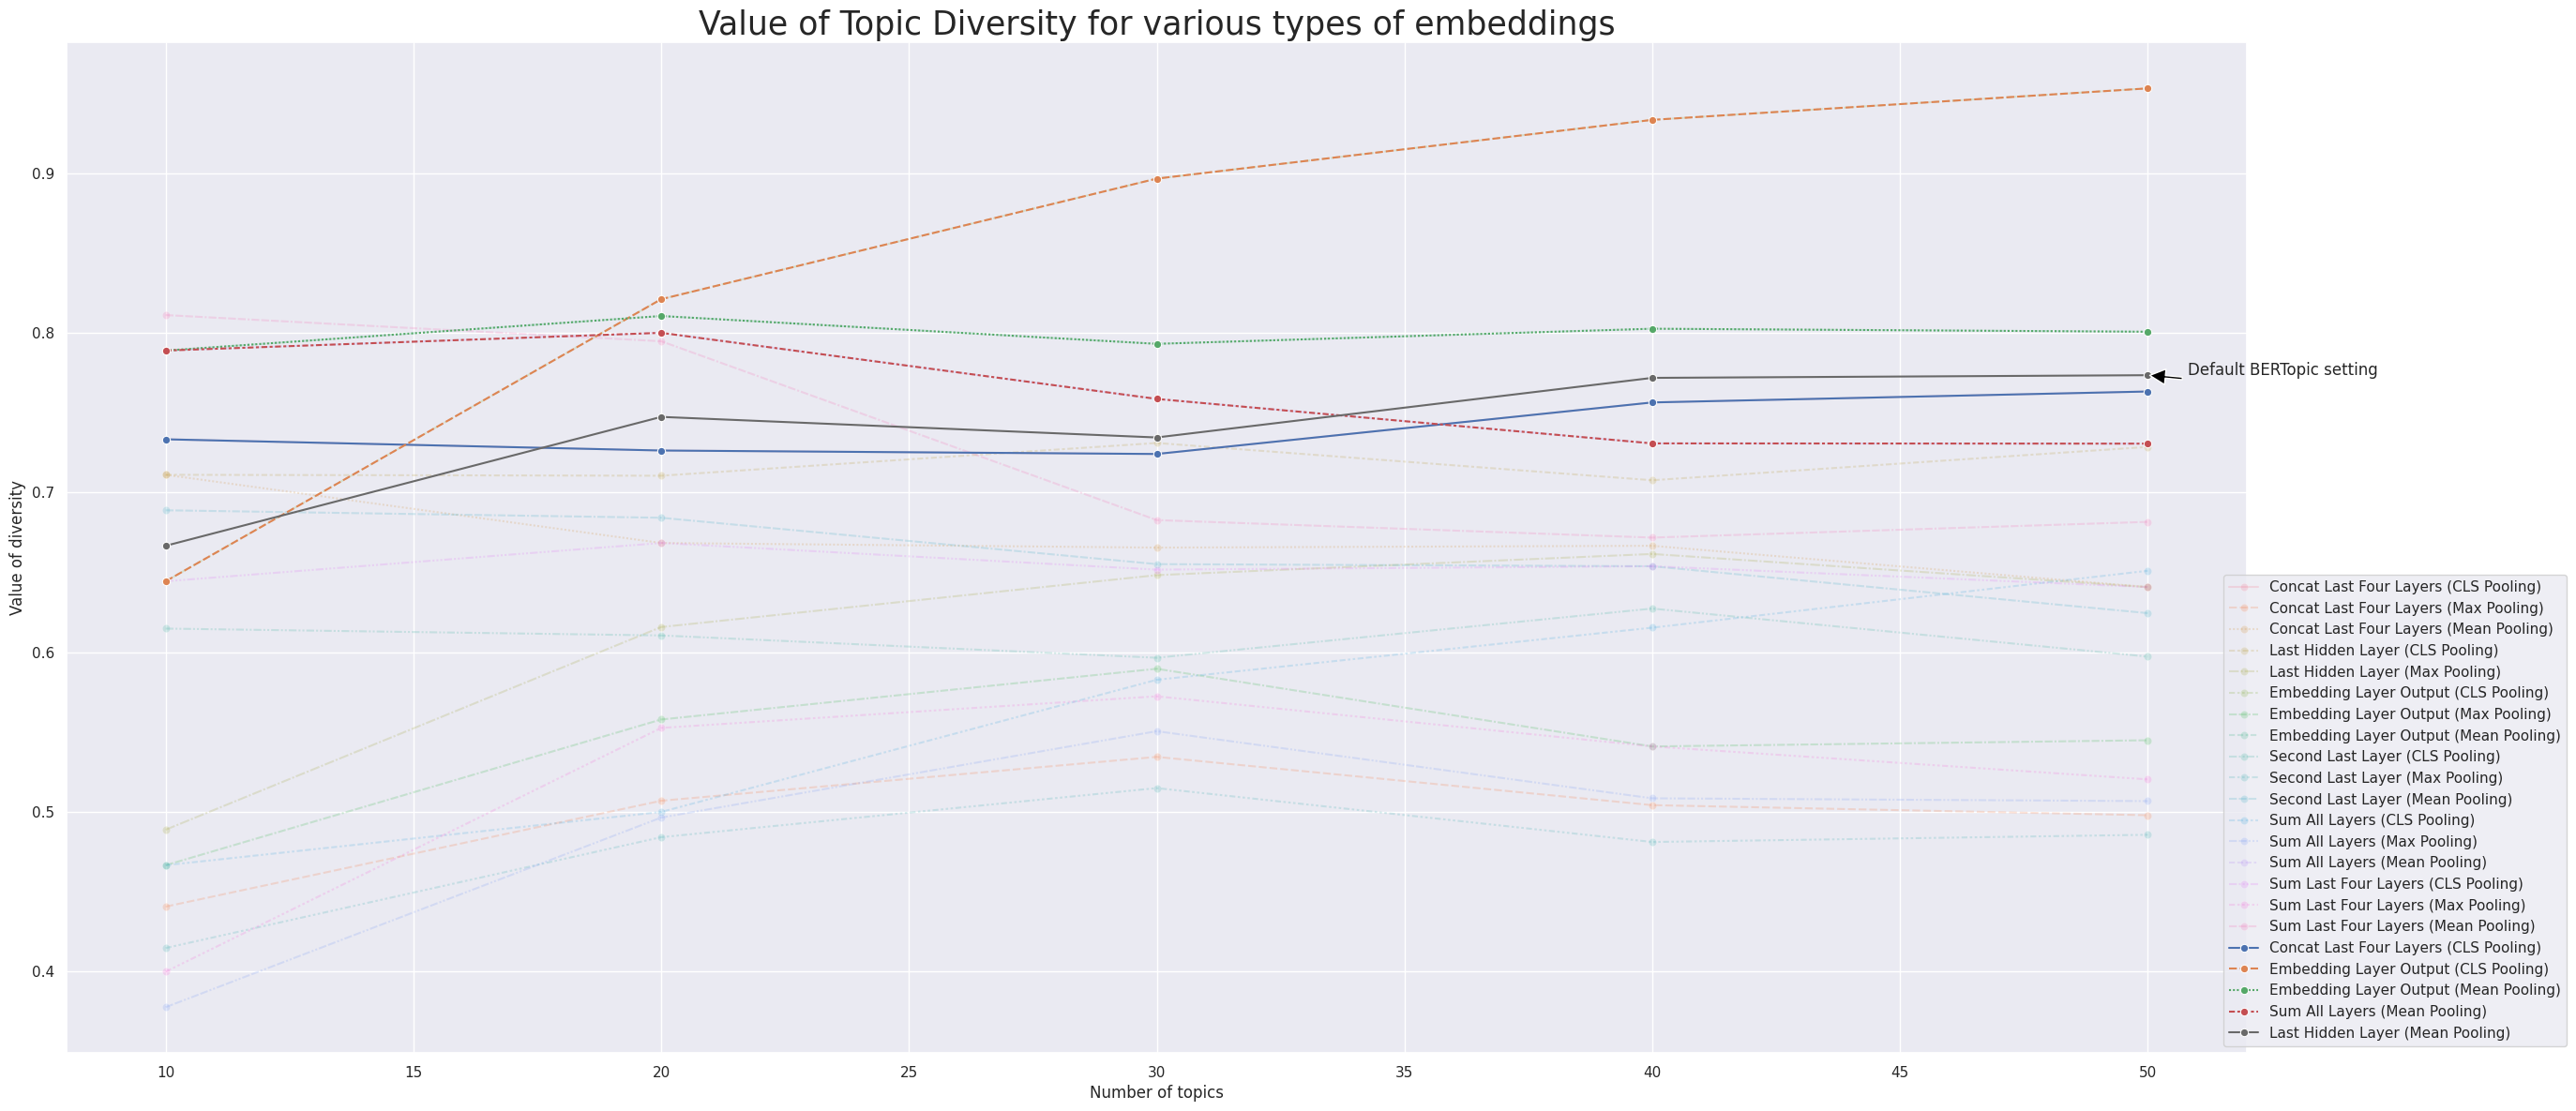

In [35]:
fig, ax = plt.subplots()
sns.lineplot(
    data=results_grouped,
    x="nr_topics",
    y="diversity",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=0.2,
    marker="o",
    ax=ax,
)
sns.lineplot(
    data=results_grouped[results_grouped["embedding_retrieval_type"].isin(top_categories_diversity)],
    x="nr_topics",
    y="diversity",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=1,
    marker="o",
    ax=ax,
)

sns.lineplot(
    data=default_setting,
    x="nr_topics",
    y="diversity",
    style="embedding_retrieval_type",
    color="dimgrey",
    alpha=1,
    marker="o",
    ax=ax,
)
plt.xlabel("Number of topics")
plt.ylabel("Value of diversity")
plt.title("Value of Topic Diversity for various types of embeddings", size=25)

line = ax.lines[-2]
x_data = line.get_xdata()
y_data = line.get_ydata()
x_to_annotate = x_data[-1]
y_to_annotate = y_data[-1]

ax.annotate(
    "Default BERTopic setting",
    xy=(x_to_annotate, y_to_annotate),
    xytext=(x_to_annotate + 0.8, y_to_annotate),
    arrowprops=dict(facecolor="black", shrink=0.05, width=2),
)

ax.legend(loc="lower right", bbox_to_anchor=(1.15, 0))
plt.show()